In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
X_train = pd.read_csv('data/input/standardized_X_train.csv', index_col=0)
y_train = pd.read_csv('data/input/y_log_train.csv', index_col=0)

In [3]:
X_test = pd.read_csv('data/input/standardized_X_test.csv', index_col=0)

### 10-fold Cross-Validation

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

In [5]:
from sklearn.metrics import mean_squared_error

In [6]:
def kfold_mse_lr(X, y, k=10):
    kf = KFold(n_splits=k)
    mses = []
    for i, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_val)
        predicted_sales = np.exp(y_pred)
        real_sales = np.exp(y_val['sales'])
        mses.append(mean_squared_error(real_sales, predicted_sales))
    return mses

In [7]:
cv_errors = kfold_mse_lr(X_train, y_train, k=10)

Export to csv for in-sample analysis points

In [8]:
cv_df = pd.DataFrame(cv_errors, columns=['Cross-Validation MSE'])
cv_df

,Cross-Validation MSE
0,5.954818e+22
1,3.330583e+02
2,5.727314e+02
3,3.181572e+02
4,5.258025e+02
5,2.873840e+02
6,7.175959e+02
7,4.681455e+02
8,1.070533e+05
9,2.575925e+02


In [9]:
cv_df.to_csv('data/output/cv/lr_log.csv')

### Model fitting

After finding best parameters (not applicable to LR but useful for other models), we fit the model on the entire training set and predict on the test set. Also, we collect residuals to prepare for inventory decision making.

In [10]:
lr = LinearRegression()
lr.fit(X_train, y_train)
residuals = np.exp(y_train) - np.exp(lr.predict(X_train))

In [11]:
output_df = X_test.copy()

In [12]:
output_df['sales'] = np.exp(lr.predict(X_test))

### Inventory decision
As sales data come from a natural process, we shall not assume it is distributed in any particular model. Hence, we shall use an empirical distribution to make our inventory decision. 

In [13]:
residuals = residuals['sales']
residuals.describe()

count    2.211000e+03
mean    -1.121940e+03
std      5.288537e+04
min     -2.486730e+06
25%     -2.873663e+00
50%      3.988617e-01
75%      6.677863e+00
max      2.702401e+02
Name: sales, dtype: float64

For visualization of Empirical CDF, we use the `statsmodels` package:

In [14]:
from statsmodels.distributions.empirical_distribution import ECDF

In [15]:
ecdf = ECDF(residuals)

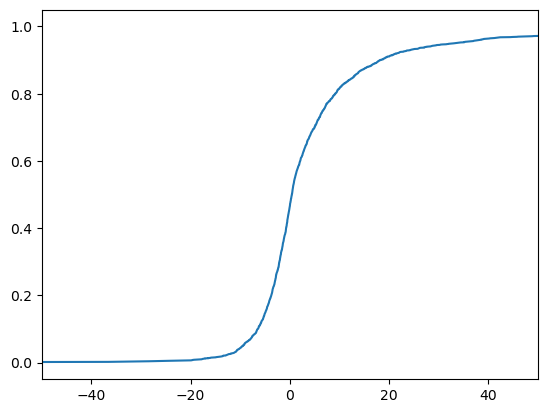

In [16]:
plt.plot(ecdf.x, ecdf.y)
plt.xlim(-50, 50)
plt.show()

Sparsity is not a concern since we have a large sample size. Therefore, we can use interpolation to obtain ppf. To get the empirical ppf, we can use scipy's `interp1d` to get the inverse function:

In [17]:
from scipy.interpolate import interp1d

In [18]:
eppf = interp1d(ecdf.y, ecdf.x)

Calculate the critical fractile

In [19]:
price = 20
cost = 12
salvage = 8
over = cost - salvage
under = price - cost
critical_fractile = under / (over + under)
critical_fractile

0.6666666666666666

We offset our predictions for the test datasets by the $eppf(critical\_fractile)$ to get the optimal inventory level.

In [20]:
output_df['inventory'] = eppf(critical_fractile) + output_df['sales']

In [21]:
output_df[['sales', 'inventory']].head()

,sales,inventory
0,45.976252,49.802464
1,41.861854,45.688066
2,17.314815,21.141028
3,22.407036,26.233248
4,5.799737,9.625949


In [22]:
output_df.to_csv('data/output/predictions/lr_log.csv')

### Conclusion
Compared with the non-log sales data, using log of sales values actually give a worst fit, especially for one fold during cross-validation. However, both models observe high MSEs during cross-validation, which indicates that simple linear regression is not a good model for this dataset and perhaps sales values are dependent on polynomial combinations of some predictors.